# Course Capstone Final Project

This jupyter notebook will be used for the capstone project. This is the last course in the 9-part data science professional certification series

In [193]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Part 1 - Creating the pandas DataFrame

None


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [198]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
df.head(10)

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [137]:
# Ignore cells without a borough assigned
df = df[df['Borough'] != 'Not assigned']
df.head(10)

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [138]:
#C Group data by the postal Code
df_new = df.groupby('Postal Code', sort=False).agg(', '.join)
df_new.head(10)

,Borough,Neighborhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
M1B,Scarborough,"Malvern, Rouge"
M3B,North York,Don Mills
M4B,East York,"Parkview Hill, Woodbine Gardens"


In [139]:
#Replace cells with a borough but a NOt assigned neighborhood with the neighborhood same as the borough
df_new.loc[df_new['Neighborhood'] =='Not assigned', 'Neighborhood'] = df_new.loc[df_new['Neighborhood'] =='Not assigned', 'Borough']
df_new.reset_index(inplace=True)
df_new.head(10)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [140]:
df_new.shape

(103, 3)

## Part 2 - Adding the Latitudes and Longitude Coordinates

In [141]:
df_new['Latitude'] = None
df_new['Longitude'] = None
df_new.head(5)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,None,None
1,M4A,North York,Victoria Village,None,None
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",None,None
3,M6A,North York,"Lawrence Manor, Lawrence Heights",None,None
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",None,None


In [142]:
#!pip install geocoder
#import geocoder
#print('Done')

for i, pc in enumerate(df_new['Postal Code']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(pc))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df_new.loc[i, 'Latitude'] = latitude
    df_new.loc[i, 'Longitude'] = longitude

df_new.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7525,-79.3299
1,M4A,North York,Victoria Village,43.7306,-79.3131
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6551,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7233,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6625,-79.3919
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.6626,-79.5283
6,M1B,Scarborough,"Malvern, Rouge",43.8114,-79.1966
7,M3B,North York,Don Mills,43.7492,-79.3619
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7072,-79.3119
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6574,-79.378


In [143]:
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="my-Toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Visualize a map of Toronto with neighbourhoods superimposed

In [144]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_new['Latitude'], df_new['Longitude'], df_new['Borough'], df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Four square Credentials

In [145]:
CLIENT_ID = 'PDGX0B2DRB4TG0FDDVMCZC43OT5KTTDGFTASV15XW4KDXPCR' # your Foursquare ID
CLIENT_SECRET = 'DW0NUVCPOLF5CRJGDS0LLKFYM53FV3WRARIHSRLZS3SACX4J' # your Foursquare Secret
VERSION = '20201227' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PDGX0B2DRB4TG0FDDVMCZC43OT5KTTDGFTASV15XW4KDXPCR
CLIENT_SECRET:DW0NUVCPOLF5CRJGDS0LLKFYM53FV3WRARIHSRLZS3SACX4J


### Function to process all neighbourhoods and return nearby venues

In [146]:

import requests
LIMIT = 50
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [147]:
venues = getNearbyVenues(names=df_new['Neighborhood'], latitudes=df_new['Latitude'], longitudes=df_new['Longitude'])


In [148]:
print(venues.shape)
venues.head

(1802, 7)


<bound method NDFrame.head of                                            Neighborhood  \
0                                             Parkwoods   
1                                             Parkwoods   
2                                             Parkwoods   
3                                      Victoria Village   
4                                      Victoria Village   
5                                      Victoria Village   
6                             Regent Park, Harbourfront   
7                             Regent Park, Harbourfront   
8                             Regent Park, Harbourfront   
9                             Regent Park, Harbourfront   
10                            Regent Park, Harbourfront   
11                            Regent Park, Harbourfront   
12                            Regent Park, Harbourfront   
13                            Regent Park, Harbourfront   
14                            Regent Park, Harbourfront   
15                        

In [274]:
venues.groupby('Neighborhood', as_index=False)
venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75245,-79.32991,Brookbanks Pool,43.751389,-79.332184,Pool
2,Parkwoods,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park
4,Victoria Village,43.73057,-79.31306,Memories of Africa,43.726602,-79.312427,Grocery Store
5,Victoria Village,43.73057,-79.31306,Guardian Drug,43.730584,-79.307432,Pharmacy
6,"Regent Park, Harbourfront",43.65512,-79.36264,Roselle Desserts,43.653447,-79.362017,Bakery
7,"Regent Park, Harbourfront",43.65512,-79.36264,Tandem Coffee,43.653559,-79.361809,Coffee Shop
8,"Regent Park, Harbourfront",43.65512,-79.36264,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
9,"Regent Park, Harbourfront",43.65512,-79.36264,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [150]:
# Check unique categories

print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 239 uniques categories.


### Venue Weights used in K-means clustering

In [230]:
# Weight venues
venue_weights = np.ones(239)
indices_high = [9,16,63,68,91]
indices_mid = [58,54,96,111,153,209,213,222]

for i in indices_high:
    venue_weights[i] = 5

for i in indices_mid:
    venue_weights[i] = 3
    
pd.DataFrame(venues['Venue Category'].unique())

,0
0,Park
1,Pool
2,Food & Drink Shop
3,Grocery Store
4,Pharmacy
5,Bakery
6,Coffee Shop
7,Breakfast Spot
8,Event Space
9,Yoga Studio


# Part 3 - Analysis

In [151]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
#Adding the neighbourhood column into venues
venues_onehot['Neighborhood'] = venues['Neighborhood']
venues_onehot.head()
temp = list(venues_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Neighborhood,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [152]:
# Examine dataframe size
venues_onehot.shape

(1802, 239)

In [241]:
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.shape

(98, 239)

In [232]:
# Sort venues in descneding order function
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [234]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Bakery,Department Store,Shopping Mall,Bubble Tea Shop,Supermarket,Sushi Restaurant,Badminton Court,Discount Store,Skating Rink
1,"Alderwood, Long Branch",Convenience Store,Performing Arts Venue,Gym,Pub,Donut Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Business Service,Yoga Studio,Construction & Landscaping,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
3,Bayview Village,Trail,Construction & Landscaping,Park,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Thai Restaurant,Liquor Store,Butcher,Café,Sports Club,Restaurant,Juice Bar


[0.2330153618501698, 0.23834448030964356, 0.3409902154488759, 0.19637496900241552, 0.18461198098224174, 0.22180085955386575, 0.21207812343414137, 0.21102500517833098, 0.13052623921880124, 0.18776404927259402, 0.21901508907173542, 0.20871345750330272, 0.21228844768335878, 0.21251105102794143]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


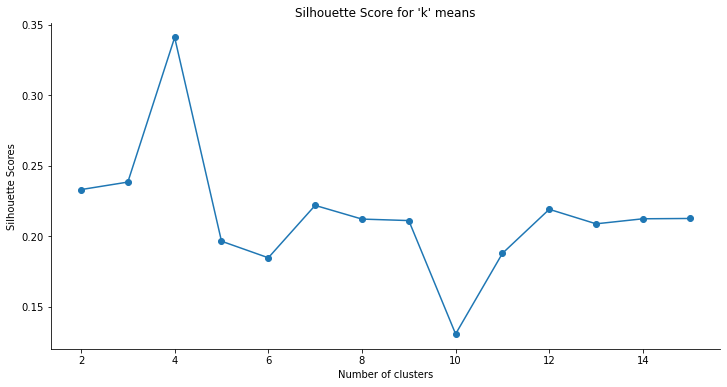

In [270]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Silhouette Score for \'k\' means')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    toronto_grouped_clustering = venues_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(toronto_grouped_clustering) #Choose any random_state
    
    score = silhouette_score(toronto_grouped_clustering, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)
    
print(scores)
print(kval)
plot(kval, scores)

## Cluster Neighbourhoods

In [267]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = venues_grouped.drop('Neighborhood', axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=67).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 3, 2, 2, 2, 2, 2, 2])

In [268]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)

toronto_merged = df_new

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(inplace=True)

toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

## Visualize Data

In [269]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [170]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,0,Food & Drink Shop,Pool,Park,Yoga Studio,Donut Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
1,North York,0,Pharmacy,Grocery Store,Park,Yoga Studio,Donut Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
18,Scarborough,0,Construction & Landscaping,Gym / Fitness Center,Park,Donut Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
27,North York,0,Park,Residential Building (Apartment / Condo),Yoga Studio,Donut Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
32,Scarborough,0,Restaurant,Grocery Store,Park,Indian Restaurant,Yoga Studio,Ethiopian Restaurant,Electronics Store,Elementary School,Escape Room,Falafel Restaurant
35,East York,0,Park,Home Service,Intersection,Falafel Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Yoga Studio
45,North York,0,Park,Yoga Studio,Donut Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
66,North York,0,Speakeasy,Coffee Shop,Park,Convenience Store,Gym Pool,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
68,Central Toronto,0,Park,Yoga Studio,Donut Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
69,West Toronto,0,Park,Residential Building (Apartment / Condo),Sandwich Place,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space


### Cluster 2

In [171]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,1,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Field,Farmers Market,Farm,Falafel Restaurant,Event Space


### Cluster 3

In [172]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,2,Coffee Shop,Breakfast Spot,Yoga Studio,Thai Restaurant,Gym / Fitness Center,Italian Restaurant,Food Truck,Event Space,Electronics Store,Distribution Center
3,North York,2,Clothing Store,Men's Store,Food Court,Restaurant,Cosmetics Shop,Toy / Game Store,Bookstore,Furniture / Home Store,American Restaurant,Women's Store
4,Downtown Toronto,2,Coffee Shop,Sandwich Place,Portuguese Restaurant,Bank,Mediterranean Restaurant,Italian Restaurant,Gastropub,Theater,Café,Fried Chicken Joint
5,Etobicoke,2,Pharmacy,Grocery Store,Café,Bank,Skating Rink,Shopping Mall,Park,Farm,Farmers Market,Falafel Restaurant
7,North York,2,Coffee Shop,Burger Joint,Intersection,Supermarket,Bubble Tea Shop,Gas Station,Clothing Store,Beer Store,Grocery Store,Gym
8,East York,2,Pizza Place,Flea Market,Intersection,Rock Climbing Spot,Café,Fast Food Restaurant,Pet Store,Breakfast Spot,Bank,Gastropub
9,Downtown Toronto,2,Coffee Shop,Café,Cosmetics Shop,Ramen Restaurant,Clothing Store,Bookstore,Theater,Music Venue,Fast Food Restaurant,Pizza Place
10,North York,2,Grocery Store,Pizza Place,Pub,Fast Food Restaurant,Latin American Restaurant,Mediterranean Restaurant,Bakery,Japanese Restaurant,Gas Station,Bank
11,Etobicoke,2,Pizza Place,Tea Room,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant
12,Scarborough,2,Construction & Landscaping,Bar,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm


### Cluster 4

In [173]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Scarborough,3,Trail,Yoga Studio,Donut Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
39,North York,3,Trail,Construction & Landscaping,Park,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm
49,North York,3,Bakery,Park,Trail,Yoga Studio,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


### Cluster 5

In [175]:
#toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]